In [104]:
import numpy as np
import pandas as pd
import shutil
import skimage.io
from sklearn.ensemble import BaggingClassifier
import os
import skimage.transform
from sklearn.neural_network import MLPClassifier
from os import listdir
from sklearn.ensemble import GradientBoostingClassifier
import sys
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
from natsort import natsorted
import cv2
import os
import h5py
import matplotlib.pyplot as plt 

from skimage.feature import hog
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib

In [105]:
labels = pd.read_csv("./bonus-sml-2020/SML_Train.csv") # seprating files class wise

# Create `train_sep` directory
train_dir='./bonus-sml-2020/SML_Train/'
train_sep_dir='./bonus-sml-2020/train_sep/'
if not os.path.exists(train_sep_dir):
    os.mkdir(train_sep_dir)

for filename,class_name in labels.values:
    # Create subdirectory with `class_name`
    if not os.path.exists(train_sep_dir + str(class_name)):
        os.mkdir(train_sep_dir + str(class_name))
    src_path = train_dir + filename
    dst_path = train_sep_dir + str(class_name) + '/' + filename
    shutil.copy(src_path, dst_path)

In [118]:
#images_per_class = 80
fixed_size       = tuple((500, 500))
train_path       = "./bonus-sml-2020/train_sep_new/"
h5_data          = './bonus-sml-2020/output/data.h5'
h5_labels        = './bonus-sml-2020/output/labels.h5'
bins             = 8

In [119]:
def hogD(image,hog_pixels_per_cell=64,hog_cells_per_block=1):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    #img=skimage.transform.resize(img_gray,(300,250)) ##resize to a suitable dimension, avg size of images in the dataset
    #original, histograms=6
    hog_desriptor=hog(gray, orientations=8, pixels_per_cell=(hog_pixels_per_cell, hog_pixels_per_cell),cells_per_block=(hog_cells_per_block, hog_cells_per_block),feature_vector=True)
    return hog_desriptor
    
    

In [120]:
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [121]:
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

In [122]:
def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()

In [123]:
train_labels = os.listdir(train_path)
print(train_labels)
train_labels = list(map(int, train_labels))

# sort the training labels
train_labels.sort()
print(train_labels)

# empty lists to hold feature vectors and labels
global_features = []
labels          = []

['20', '18', '9', '0', '11', '7', '16', '6', '17', '1', '10', '19', '8', '21', '24', '23', '4', '15', '3', '12', '2', '13', '5', '14', '22']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


In [124]:
# mom: (7,)
# har: (13,)
# hist: (512,)
# gloval: (532,)

In [125]:
training_data_feature_map={} 
daisy_descriptor_list=[]
for training_name in train_labels:
    # join the training data path and each species training folder
    dir = os.path.join(train_path, str(training_name))

    # get the current training label
    current_label = training_name
    
    # loop over the images in each sub-folder
    for file in listdir(dir):
        # get the image file name
        # read the image and resize it to a fixed-size
        image = cv2.imread(dir+'/'+file)
        image = cv2.resize(image, fixed_size)
        
#         daisy_features,hog_feature=extract_daisy_and_hog_features_from_image(dir+'/'+file,daisy_step_size=8,daisy_radius=8)
#         training_data_feature_map[dir+'/'+file]=[daisy_features,hog_feature]
#         daisy_descriptor_list=daisy_descriptor_list+list(daisy_features)

        ####################################
        # Global Feature extraction
        ####################################
        fv_hu_moments = fd_hu_moments(image)
        #print("mom:",fv_hu_moments.shape)
        fv_haralick   = fd_haralick(image)
        #print("har:",fv_haralick.shape)
        fv_histogram  = fd_histogram(image)
        
        hog_des=hogD(image)
        #print("hist:",fv_histogram.shape)
        ###################################
        # Concatenate global features
        ###################################
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments,hog_des])
        #print("gloval:",global_feature.shape)

        # update the list of labels and feature vectors
        labels.append(current_label)
        global_features.append(global_feature)

    print(len(global_features[0]))

print("Done")

924
924
924
924
924
924
924
924
924
924
924
924
924
924
924
924
924
924
924
924
924
924
924
924
924
Done


In [126]:
print(np.array(global_features).shape)

# get the overall training label size
print(np.array(labels).shape)

# encode the target labels
# targetNames = np.unique(labels)
# le          = LabelEncoder()
# target      = le.fit_transform(labels)
# print("[STATUS] training labels encoded...")
target=labels
print(np.array(target).shape)

# scale features in the range (0-1)
scaler            = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)


# save the feature vector using HDF5
h5f_data = h5py.File(h5_data, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

h5f_label = h5py.File(h5_labels, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

h5f_data.close()
h5f_label.close()

print("[STATUS] end of training..")

(24315, 924)
(24315,)
(24315,)
[STATUS] end of training..


In [127]:
num_trees = 700
test_size = 0.10
seed      = 9
train_path = "./bonus-sml-2020/train_sep/"
test_path  = "./bonus-sml-2020/SML_Test/"
h5_data          = './bonus-sml-2020/output/data.h5'
h5_labels        = './bonus-sml-2020/output/labels.h5'
scoring    = "accuracy"

In [128]:
models = []
#models.append(('LR', LogisticRegression(random_state=seed)))
#models.append(('LDA', LinearDiscriminantAnalysis()))
#models.append(('KNN', KNeighborsClassifier()))
#models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_depth=50,random_state=0,min_samples_split=2)))
#models.append(('GB',GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, max_depth=2, random_state=0)))
#models.append(('NB', GaussianNB()))
#svm=SVC(kernel='rbf', class_weight='balanced',C=5,gamma=0.005,random_state=seed)
#models.append(('SVM', SVC(kernel='rbf', class_weight='balanced',C=5,gamma=0.005,random_state=seed) ))
#models.append(('SVM', BaggingClassifier(base_estimator=svm, n_estimators=100, random_state=42) ))
#models.append((BaggingClassifier(base_estimator=svm, n_estimators=31, random_state=42))
#models.append(('SVM', SVC(random_state=seed)))
print(models)

results = []
names   = []

# import the feature vector and trained labels
h5f_data  = h5py.File(h5_data, 'r')
h5f_label = h5py.File(h5_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

print(np.array(global_features).shape)

# get the overall training label size
print(np.array(global_labels).shape)

[('RF', RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=700,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False))]
(24315, 924)
(24315,)


In [129]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print("[STATUS] splitted train and test data...")
print("Train data  : {}",trainDataGlobal.shape)
print("Test data   : {}",testDataGlobal.shape)
print("Train labels: {}",trainLabelsGlobal.shape)
print("Test labels : {}",testLabelsGlobal.shape)

[STATUS] splitted train and test data...
Train data  : {} (21883, 924)
Test data   : {} (2432, 924)
Train labels: {} (21883,)
Test labels : {} (2432,)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


RF: 0.273133 (0.011171)


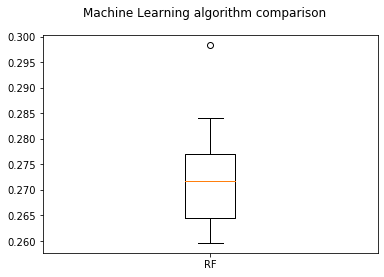

In [35]:
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [130]:
global_features_test=[]
for file in natsorted(listdir(test_path)):
        # get the image file name
        # read the image and resize it to a fixed-size
        image = cv2.imread(test_path+file)
        image = cv2.resize(image, fixed_size)

        ####################################
        # Global Feature extraction
        ####################################
        fv_hu_moments = fd_hu_moments(image)
        #print("mom:",fv_hu_moments.shape)
        fv_haralick   = fd_haralick(image)
        #print("har:",fv_haralick.shape)
        fv_histogram  = fd_histogram(image)
        #print("hist:",fv_histogram.shape)
        ###################################
        # Concatenate global features
        ###################################
        
        hog_des=hogD(image)
        #print("hist:",fv_histogram.shape)
        ###################################
        # Concatenate global features
        ###################################
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments,hog_des])
        #global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
        #print("gloval:",global_feature.shape)

        # update the list of labels and feature vectors
        global_features_test.append(global_feature)

print("Done")


Done


In [131]:
scaler            = MinMaxScaler(feature_range=(0, 1))
rescaled_features_test = scaler.fit_transform(global_features_test)


In [132]:
print(np.array(rescaled_features_test).shape)

(1500, 924)


In [17]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(trainDataGlobal, trainLabelsGlobal)
clf = rf_random.best_estimator_prediction=[]

y_test = clf.predict(rescaled_features_test)

In [133]:
import matplotlib.pyplot as plt

# create the model - Random Forests
clf  = RandomForestClassifier(n_estimators=num_trees, max_depth=50,random_state=0,min_samples_split=2)

# clf = MLPClassifier(activation='relu',solver='adam', alpha=1e-8,
#                     hidden_layer_sizes=(512,512,512), random_state=0)
#clf=LogisticRegression(random_state=seed)
#clf= SVC(kernel='rbf', class_weight='balanced',C=5,gamma=0.005)
# fit the training data to the model
clf.fit(trainDataGlobal, trainLabelsGlobal)
prediction=[]

y_test = clf.predict(rescaled_features_test)

In [134]:
print(y_test[0:20])

[ 3  2  6 15 14  9 14 22  8 16 24 10  3  9 17 22 15 10 19 10]


In [135]:
print(len(y_test))

1500


In [136]:
def helper(direc):
    files=[]
    for filename in natsorted(listdir(direc)):
        files.append(filename)
    return files

files=helper('./bonus-sml-2020/SML_Test/')
data_res=pd.DataFrame()
data_res['id']=files
data_res['category']=y_test
data_res.to_csv (r'sample_submission.csv', index = False, header=True)

# next


In [9]:
train_path       = "./bonus-sml-2020/train_sep_new/"

(<matplotlib.axes._subplots.AxesSubplot at 0x1a23fab190>,
 <matplotlib.image.AxesImage at 0x1a245f7450>)

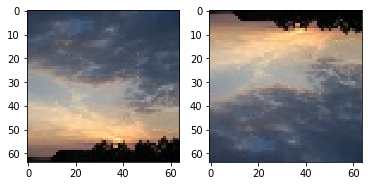

In [12]:
img = cv2.imread('./bonus-sml-2020/SML_Test/Test_128.jpg') 
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
horizontal_img = img.copy()
vertical_img = img.copy()
both_img = img.copy()
 
# flip img horizontally, vertically,
# and both axes with flip()
horizontal_img = cv2.flip( img, 0 )
vertical_img = cv2.flip( img, 1 )
both_img = cv2.flip( img, -1 )
 
# plt.subplot(121),plt.imshow(img)
# plt.subplot(122),plt.imshow(both_img)
# plt.subplot(121),plt.imshow(img)
# plt.subplot(122),plt.imshow(vertical_img)
plt.subplot(121),plt.imshow(img)
plt.subplot(122),plt.imshow(horizontal_img)

In [91]:
    hog_pixels_per_cell=64
    hog_cells_per_block=1
    image = cv2.imread('./bonus-sml-2020/SML_Test/Test_128.jpg')
    image = cv2.resize(image, fixed_size)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    #img=skimage.transform.resize(img_gray,(300,250)) ##resize to a suitable dimension, avg size of images in the dataset
    #original, histograms=6
    hog_desriptor=hog(gray, orientations=8, pixels_per_cell=(hog_pixels_per_cell, hog_pixels_per_cell),cells_per_block=(hog_cells_per_block, hog_cells_per_block),feature_vector=True)
    print(len (hog_desriptor))
    
    

392


In [112]:
def imageAugmntation(image,count,target_dir):
    #flip
    img = cv2.imread(image) 
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    vertical_img = img.copy()
    vertical_img = cv2.flip( img, 1 )
    #print(target_dir+'/'+'Train_'+str(count)+'.jpg')
    cv2.imwrite(target_dir+'/'+'Train_'+str(count)+'.jpg',cv2.cvtColor(vertical_img, cv2.COLOR_BGR2RGB))

In [113]:
def Gaussinablur(image,count,target_dir):
    img = cv2.imread(image) 
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    blur=cv2.GaussianBlur(img,(9,9),0)
    print(target_dir+'/'+'Train_'+str(count)+'.jpg')
    cv2.imwrite(target_dir+'/'+'Train_'+str(count)+'.jpg',cv2.cvtColor(vertical_img, cv2.COLOR_BGR2RGB))

In [114]:
for training_name in train_labels:
    # join the training data path and each species training folder
    dir = os.path.join(train_path, str(training_name))
    # loop over the images in each sub-folder
    count=0
    for f in os.listdir(dir):
        if not f.startswith('.'):
            count+=1
    
    file_name=16000
    for file in listdir(dir):
        if not file.startswith('.'):
            if(count<=982):
                imageAugmntation(dir+'/'+file,file_name,dir)
                file_name+=1
                count+=1
    print(count)

983
983
972
983
983
983
896
908
983
983
983
896
983
983
983
983
983
983
983
983
983
983
983
983
983


In [115]:
count=0
for training_name in train_labels:
    # join the training data path and each species training folder
    dir = os.path.join(train_path, str(training_name))
    # loop over the images in each sub-folder
   
    for f in os.listdir(dir):
        if not f.startswith('.'):
            count+=1
    

In [117]:
count

24315

In [34]:
len(os.listdir('./bonus-sml-2020/SML_Test'))

1500